# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Distribution of Bias Categories (Bar Plot, Sorted by Frequency)

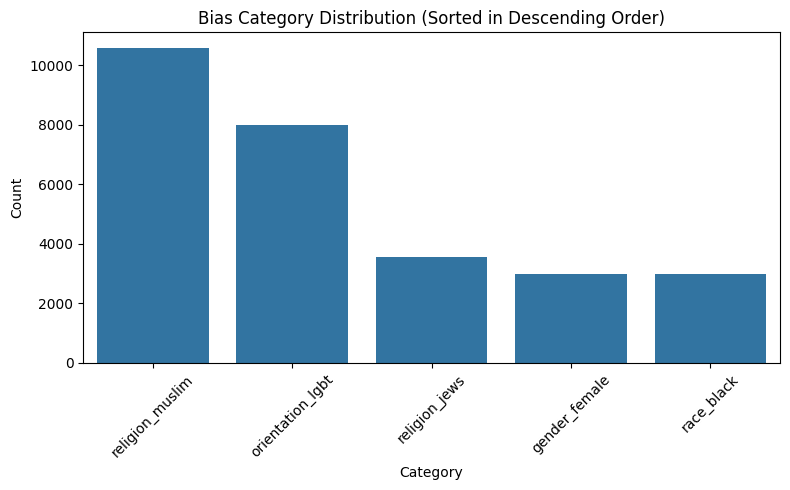

In [2]:
cleaned_df = pd.read_csv('data/cleaned_data.csv')
plt.figure(figsize=(8, 5))
order = cleaned_df['category'].value_counts().index
sns.countplot(data=cleaned_df, x='category', order=order)
plt.title('Bias Category Distribution (Sorted in Descending Order)')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comment Length Distribution by Category (Boxplot)

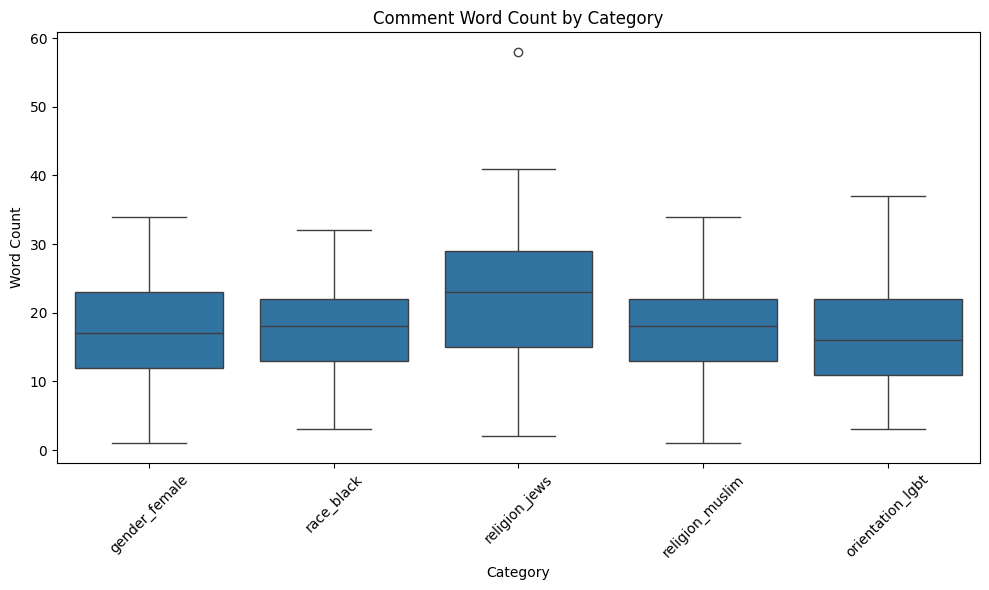

In [3]:
# Add a column for comment length (number of words)
cleaned_df['comment_word_count'] = cleaned_df['comment'].astype(str).apply(lambda x: len(x.split()))

# Boxplot of comment length by category
plt.figure(figsize=(10, 6))
sns.boxplot(data=cleaned_df, x='category', y='comment_word_count')
plt.title('Comment Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comment Length Distribution by Category (Histogram)

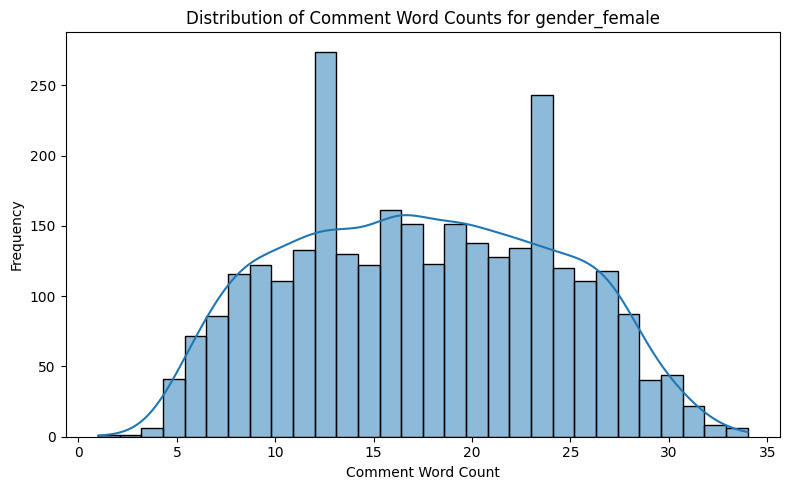

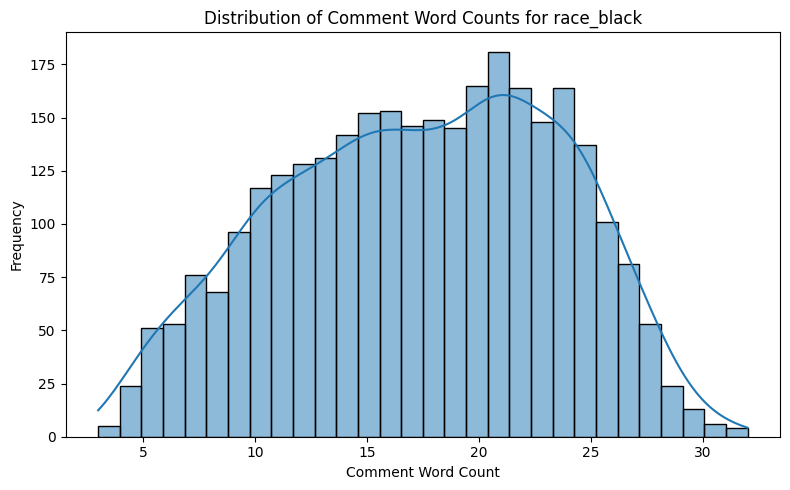

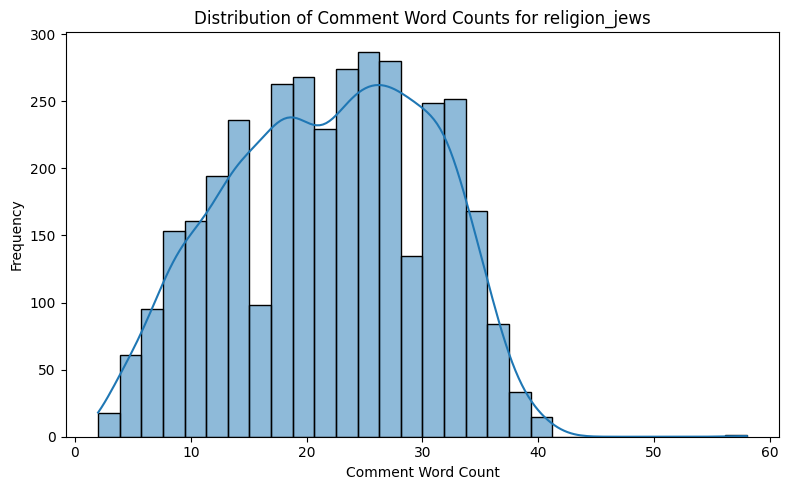

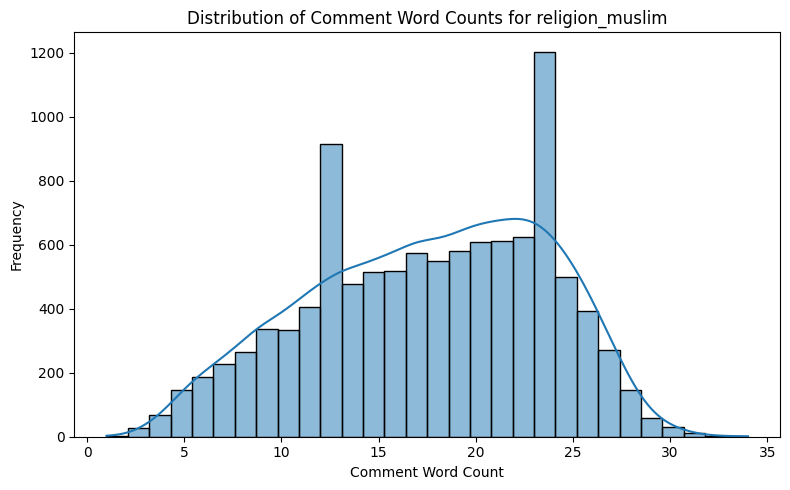

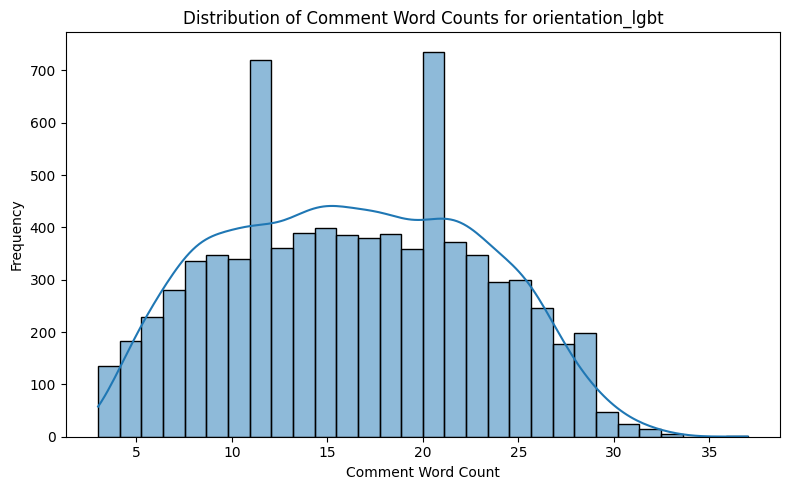

In [4]:
# Histogram of comment lengths
categories = cleaned_df['category'].unique()
for cat in categories:
    plt.figure(figsize=(8, 5))
    subset = cleaned_df[cleaned_df['category'] == cat]
    sns.histplot(subset['comment_word_count'], bins=30, kde=True)
    plt.title(f'Distribution of Comment Word Counts for {cat}')
    plt.xlabel('Comment Word Count')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Tokenization

In [5]:
from pathlib import Path
import os, pandas as pd
from datasets import Dataset, load_from_disk
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

PROJECT_ROOT = Path.cwd()
DATA_IN = PROJECT_ROOT / "data" / "cleaned_data.csv"
DATA_OUT_DIR = PROJECT_ROOT / "data" / "tokenized_bert_uncased_max128"
MAX_LEN = 128
REMOVE_STOPWORDS = False

assert DATA_IN.exists(), f"Missing file: {DATA_IN}"


df = pd.read_csv(DATA_IN, usecols=["comment", "bias_sent", "category"]).dropna(subset=["comment","bias_sent"])

labels_num = pd.to_numeric(df["bias_sent"], errors="coerce")
mask = labels_num.isin([0, 1])
dropped = (~mask | labels_num.isna()).sum()
df = df.loc[mask, ["comment", "category"]].copy()
df["labels"] = labels_num.loc[mask].astype(int)


def maybe_remove_stopwords(text: str) -> str:
    if not REMOVE_STOPWORDS:
        return str(text)
    toks = [w for w in str(text).split() if w.lower() not in ENGLISH_STOP_WORDS]
    return " ".join(toks)

df["text"] = df["comment"].astype(str).apply(maybe_remove_stopwords)

print(f"Rows kept: {len(df)} | Dropped (invalid labels): {int(dropped)}")

# tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", use_fast=True)


ds = Dataset.from_pandas(df[["text", "labels", "category"]], preserve_index=False)

def tok(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

ds = ds.map(tok, batched=True, desc="Tokenizing")

# keep standard columns
keep = ["input_ids", "attention_mask", "labels", "category"]
if "token_type_ids" in ds.column_names:
    keep.insert(1, "token_type_ids")
ds = ds.select_columns(keep)


DATA_OUT_DIR.mkdir(parents=True, exist_ok=True)
ds.save_to_disk(str(DATA_OUT_DIR))
print(f"Saved tokenized dataset to: {DATA_OUT_DIR}")


/Users/hiepng05/HIEP/COMPUTER_SCIENCE/GitHub/language-bias/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Rows kept: 11492 | Dropped (invalid labels): 47


Saving the dataset (1/1 shards): 100%|██████████| 11492/11492 [00:00<00:00, 1306081.60 examples/s]

Saved tokenized dataset to: /Users/hiepng05/HIEP/COMPUTER_SCIENCE/GitHub/language-bias/data/tokenized_bert_uncased_max128


In [6]:
# Reloading the saved dataset from disk to confirm its readable
# Print a summary object that shows columns and number of rows

loaded = load_from_disk(str(DATA_OUT_DIR))
print(loaded) 
row0 = {k: loaded[k][0] for k in ["labels","category"]}
print("Row 0 label/category:", row0)
max_len = max(len(ids) for ids in loaded["input_ids"]) if "input_ids" in loaded.column_names else 0
print("Max seq len:", max_len) 

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'category'],
    num_rows: 11492
})
Row 0 label/category: {'labels': 0, 'category': 'gender_female'}
Max seq len: 128


# Data Split

In [15]:
# Split the tokenized dataset into train/test/eval with 6:2:2 ratio
from datasets import load_from_disk, ClassLabel
import numpy as np

# Load the tokenized dataset
tokenized_data = load_from_disk("data/tokenized_bert_uncased_max128")
print(f"Total samples: {len(tokenized_data)}")

# Convert labels column to ClassLabel type for stratification
tokenized_data = tokenized_data.cast_column("labels",
ClassLabel(names=["0", "1"]))

# Set random seed for reproducibility
np.random.seed(42)

# Create stratified split to maintain category distribution
from sklearn.model_selection import train_test_split

# First split: separate train (60%) from temp (40%)
train_data, temp_data = tokenized_data.train_test_split(
    test_size=0.4,
    stratify_by_column='labels',
    seed=42
).values()

# Second split: divide temp into test (20%) and eval (20%)
test_data, eval_data = temp_data.train_test_split(
    test_size=0.5,
    stratify_by_column='labels',
    seed=42
).values()

print(f"Train set: {len(train_data)} samples ({len(train_data)/len(tokenized_data)*100:.1f}%)")
print(f"Test set: {len(test_data)} samples ({len(test_data)/len(tokenized_data)*100:.1f}%)")
print(f"Eval set: {len(eval_data)} samples ({len(eval_data)/len(tokenized_data)*100:.1f}%)")

# Save the splits
train_data.save_to_disk("data/train_split")
test_data.save_to_disk("data/test_split")
eval_data.save_to_disk("data/eval_split")

Total samples: 11492
Train set: 6895 samples (60.0%)
Test set: 2298 samples (20.0%)
Eval set: 2299 samples (20.0%)


Saving the dataset (1/1 shards): 100%|██████████| 2299/2299 [00:00<00:00, 235308.45 examples/s]


In [18]:
import pandas as pd

def analyze_split(dataset, name):
    print(f"\n{name} Dataset Analysis:")
    print(f"Total samples: {len(dataset)}")

    # Convert to pandas for easier analysis
    df = dataset.to_pandas()

    # Label distribution
    print("\nLabel distribution:")
    print(df['labels'].value_counts().sort_index())
    print(f"Bias ratio: {df['labels'].mean():.3f}")

    # Category distribution  
    print("\nCategory distribution:")
    print(df['category'].value_counts())

    return df

# Analyze each split
train_df = analyze_split(train_data, "TRAIN")
test_df = analyze_split(test_data, "TEST")
eval_df = analyze_split(eval_data, "EVAL")

# Overall summary
print(f"\n{'='*50}")
print("SUMMARY:")
print(f"Total samples: {len(tokenized_data)}")
print(f"Train: {len(train_data)} ({len(train_data)/len(tokenized_data)*100:.1f}%)")
print(f"Test:  {len(test_data)} ({len(test_data)/len(tokenized_data)*100:.1f}%)")
print(f"Eval:  {len(eval_data)} ({len(eval_data)/len(tokenized_data)*100:.1f}%)")


TRAIN Dataset Analysis:
Total samples: 6895

Label distribution:
labels
0    2940
1    3955
Name: count, dtype: int64
Bias ratio: 0.574

Category distribution:
category
gender_female       1750
race_black          1569
religion_jews       1290
orientation_lgbt    1181
religion_muslim     1105
Name: count, dtype: int64

TEST Dataset Analysis:
Total samples: 2298

Label distribution:
labels
0     980
1    1318
Name: count, dtype: int64
Bias ratio: 0.574

Category distribution:
category
gender_female       618
race_black          531
religion_jews       413
orientation_lgbt    383
religion_muslim     353
Name: count, dtype: int64

EVAL Dataset Analysis:
Total samples: 2299

Label distribution:
labels
0     980
1    1319
Name: count, dtype: int64
Bias ratio: 0.574

Category distribution:
category
gender_female       608
race_black          520
orientation_lgbt    419
religion_jews       408
religion_muslim     344
Name: count, dtype: int64

SUMMARY:
Total samples: 11492
Train: 6895 (60.0%